# Description
This kernel is based on CVPR'21 papaer "**A Novel Deep Learning Architecture for Defect Pattern Classification: Self-Proliferation-and-Attention Neural Network** (**SP&A-Net**) "

The Original code is from " https://github.com/yfyangd ". An implementation of SP&A-Net for Tensorflow 2.0+. 

## 1. Import Library & DataSet

In [37]:
# Import Tensorflow & Keras
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.utils import to_categorical
from math import ceil
from tensorflow.keras.layers import Input,MaxPooling2D, GlobalAveragePooling2D, Conv2D, Concatenate, BatchNormalization, DepthwiseConv2D, Lambda, Reshape, Layer, Activation, add
from keras_layer_normalization import LayerNormalization
import math
from keras.callbacks import Callback

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Import DataSets
from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

## 2. Data Exploration

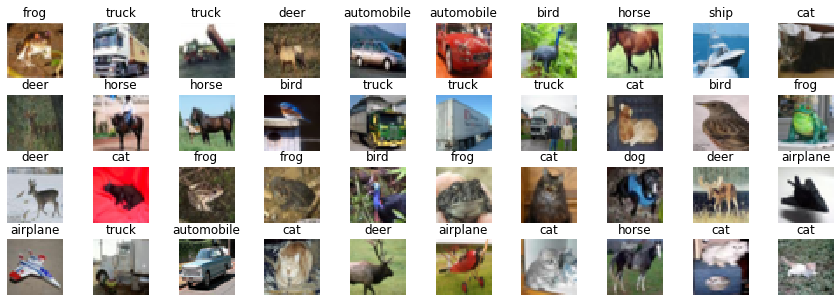

In [4]:
# dict
dictionary={1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck",0:"airplane"}
# visualizing training samples
plt.figure(figsize=(15,5))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(train_images[i].reshape((32, 32, 3)),cmap=plt.cm.hsv)
    plt.title(dictionary[train_labels[i][0]])
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## 3. Data Preprocess

In [5]:
# Normalize pixel values to be between 0 and 1
train_images.astype('float32');test_images.astype('float32')
train_images, test_images = train_images / 255.0, test_images / 255.0

In [6]:
# Encoding
train_labels = to_categorical(np.array(train_labels[:, 0]))
test_labels = to_categorical(np.array(test_labels[:, 0]))

In [9]:
inputs = np.zeros((1, train_images.shape[1], train_images.shape[2], train_images.shape[3]), dtype=np.float32)

## 4. Model Design: SP&A-Net

### Self-Attention Block

In [28]:
## Self-Attention Block
def Self_Attention_Block(inputs, filters, ratio):
    x = inputs
    x1 = Conv2D(1, (1, 1), strides=(1, 1), padding='same', use_bias=False, activation=None)(x)
    self_attention = Activation('softmax')(x1)
    x = x * self_attention
    x = Reshape((1, 1, int(x.shape[1])))(x)
    x = Conv2D(int(filters / ratio), (1, 1), strides=(1, 1), padding='same', use_bias=False, activation=None)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(filters), (1, 1), strides=(1, 1), padding='same', use_bias=False, activation=None)(x)
    excitation = Activation('hard_sigmoid')(x)
    x = inputs * excitation
    return x

### Self-Proliferate Block

In [29]:
def Self_Proliferate_Block(inputs, out, ratio, convkernel, dwkernel):
    x = inputs
    conv_out_channel = ceil(out * 1.0 / ratio)
    x = Conv2D(int(conv_out_channel), (convkernel, convkernel), use_bias=False,
               strides=(1, 1), padding='same', activation=None)(x)
    if ratio == 1:
        return x
    else:
        dw = DepthwiseConv2D(dwkernel, 1, padding='same', use_bias=False,
                            depth_multiplier=ratio-1, activation=None)(x)
        dw = dw[:, :, :, :int(out - conv_out_channel)]
        output = Concatenate()([x, dw])
        return output

### Self-Proliferate-and-Attention Block

In [33]:
def Self_Proliferate_and_Attention_Block(inputs, dwkernel, strides, exp, out, ratio, use_sa):
    x = DepthwiseConv2D(dwkernel, strides, padding='same', depth_multiplier=ratio-1,
                        activation=None, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(out, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    y = Self_Proliferate_Block(inputs, exp, ratio, 1, 3) # inputs, out, ratio(s=2, 50%), convkernel(k=1), dwkernel(d=3)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    if strides > 1:
        y = DepthwiseConv2D(dwkernel, strides, padding='same', depth_multiplier=ratio-1, 
                            activation=None, use_bias=False)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
    if use_sa:
        Self_Attention_Block(y, exp, ratio)
    y = Self_Proliferate_Block(y, out, ratio, 1, 3)
    y = BatchNormalization()(y)
    return add([x, y])

### SP&A-Net

In [34]:
def Self_Proliferate_And_Attention_Network(classes):

    img_input = keras.layers.Input(shape=(32, 32, 3))
    x = Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation=None, use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for i in range(16):
        x = Self_Proliferate_and_Attention_Block(x, dwkernels[i], strides[i], exps[i], outs[i], ratios[i], use_sa[i])
        
    x = Conv2D(960, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, int(x.shape[1])))(x)
    
    x = Conv2D(1280, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(classes, (1, 1), strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = tf.squeeze(x, 1)
    x = tf.squeeze(x, 1)
    output = Activation('softmax')(x)
    
    model = tf.keras.Model(img_input, output)
    return model

In [35]:
# Paramaters
dwkernels = [3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5]
strides = [1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]
exps = [16, 48, 72, 72, 120, 240, 200, 184, 184, 480, 672, 672, 960, 960, 960, 960]
outs = [16, 24, 24, 40, 40, 80, 80, 80, 80, 112, 112, 160, 160, 160, 160, 160]
ratios = [2] * 16
use_sa = [True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True]

In [38]:
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [39]:
model = Self_Proliferate_And_Attention_Network(classes=10)
model.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 16, 16, 16)   64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16, 16, 16)   0           batch_normalization_18[0][0]     
______________________________________________________________________________________________

In [40]:
history = model.fit(train_images, train_labels, epochs=20, validation_split=0.25)

Train on 37500 samples, validate on 12500 samples
Epoch 1/20
37500/37500 [==============================] - 400s 11ms/sample - loss: 1.9030 - accuracy: 0.3239 - val_loss: 1.8315 - val_accuracy: 0.3601
Epoch 2/20
37500/37500 [==============================] - 394s 10ms/sample - loss: 1.5532 - accuracy: 0.4407 - val_loss: 1.6165 - val_accuracy: 0.4389
Epoch 3/20
37500/37500 [==============================] - 372s 10ms/sample - loss: 1.4382 - accuracy: 0.4912 - val_loss: 1.7152 - val_accuracy: 0.4482
Epoch 4/20
37500/37500 [==============================] - 374s 10ms/sample - loss: 1.3346 - accuracy: 0.5334 - val_loss: 2.1076 - val_accuracy: 0.4282
Epoch 5/20
37500/37500 [==============================] - 376s 10ms/sample - loss: 1.2204 - accuracy: 0.5741 - val_loss: 1.2207 - val_accuracy: 0.5571
Epoch 6/20
37500/37500 [==============================] - 652s 17ms/sample - loss: 1.1618 - accuracy: 0.5946 - val_loss: 1.0906 - val_accuracy: 0.6130
Epoch 7/20
37500/37500 [====================

### SP&A-Net

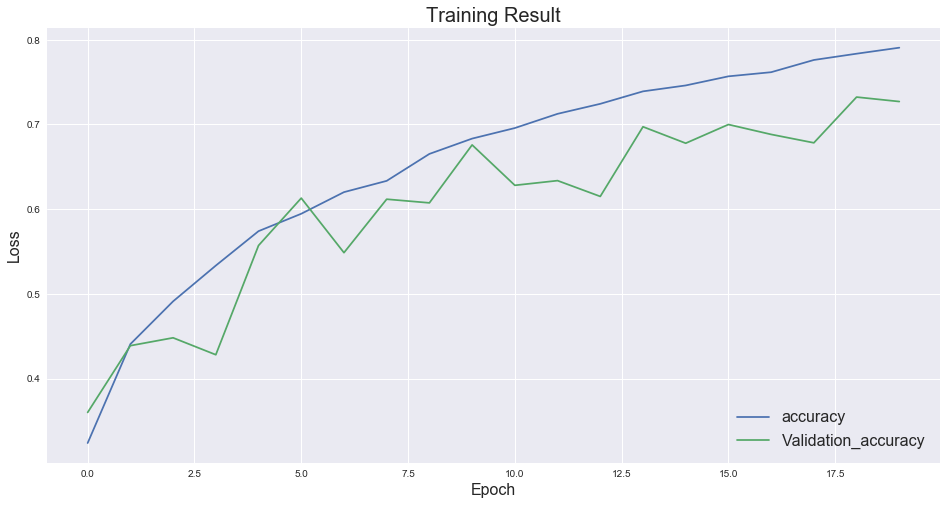

In [41]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Result',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['accuracy','Validation_accuracy'], loc='lower right',fontsize=16)
plt.show()

In [42]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('accuracy: ',score[1])
print('loss: ',score[0])

accuracy:  0.7229
loss:  0.8150102803230286


## 5.Predict Result Review

In [43]:
import matplotlib.pyplot as plot
import math
label_desc = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]
def show_feature_label_prediction( features
                                 , labels
                                 , predictions
                                 , indexList
                                 ) :
    num = len(indexList)
    plot.gcf().set_size_inches( 2*5, (2+0.4)*math.ceil(num/5) )
    loc = 0
    for i in indexList :
        loc += 1
        subp = plot.subplot( math.ceil(num/5), 5, loc )
        subp.imshow( features[i], cmap='binary' )
        if( len(predictions) > 0 ) :
            title = 'ai = ' + label_desc[ predictions[i] ]
            title += (' (o)' if predictions[i]==labels[i] else ' (x)')
            title += '\nlabel = ' + label_desc[ labels[i] ]
        else :
            title = 'label = ' + label_desc[ labels[i] ]
        subp.set_title( title, fontsize=12 )
        subp.set_xticks( [] )
        subp.set_yticks( [] )
    plot.show()

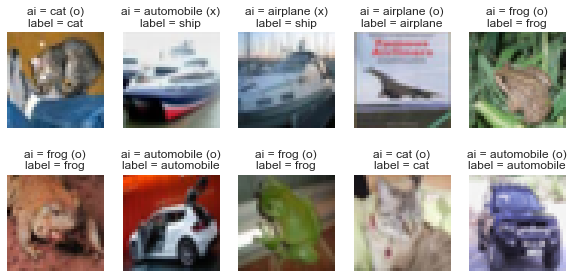

In [44]:
(train_images2, train_labels2), (test_images2, test_labels2) = cifar10.load_data()
predict = model.predict(test_images)
predict=np.argmax(predict,axis=1)
test_label_onearr = test_labels2.reshape(len(test_labels2))
show_feature_label_prediction(test_images2, test_label_onearr, predict, range(0, 10) )

Top-20 predict error list

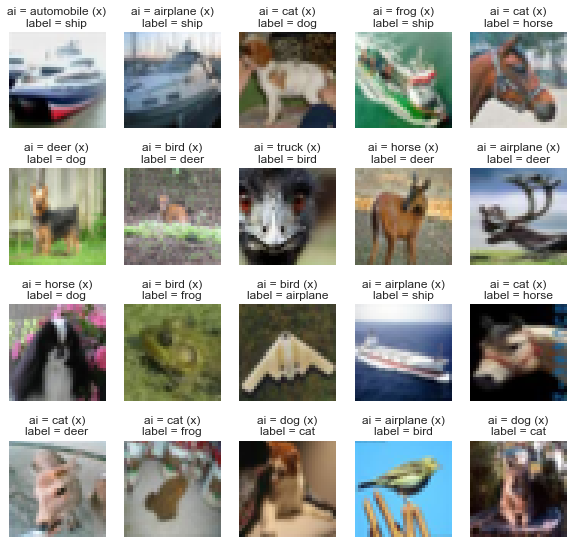

In [45]:
checkList = pd.DataFrame( {'label':test_label_onearr,'prediction':predict})
show_feature_label_prediction(test_images2, test_label_onearr, predict, checkList.index[checkList.prediction != checkList.label][0:20])